In [5]:
import numpy as np
import pandas as pd

import os
import json
import time

from IPython.display import clear_output
from IPython.display import HTML

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import colors
import numpy as np

from skimage.segmentation import flood, flood_fill

%matplotlib inline

In [6]:
# define solver
class ARCSolver:
    def __init__(self, task_filename):
        # load task and extract input and output pairs
        self.task_filename = task_filename
        self.task = self.load_task(task_filename)
        self.train_inputs, self.train_outputs, self.test_inputs, self.test_outputs = \
            self.extract_io_pairs()
        self.test_pred = np.zeros((5, 5))
        self.test_pred_height, self.test_pred_width = self.test_pred.shape
        
        self.solved = False  # have we solved the task yet?
        self.selected_colour = 0
        self.clipboard = None
        self.description = ''
        
        # variables for plotting
        self.cmap = colors.ListedColormap(
            ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
             '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
        self.colour_to_num = {'black': 0, 'blue': 1, 'red': 2, 'green': 3, 'yellow': 4,
                             'grey': 5, 'magenta': 6, 'orange': 7, 'light_blue': 8, 
                             'maroon': 9}
        self.num_to_colour = {0: 'black', 1: 'blue', 2: 'red', 3: 'green', 4: 'yellow',
                             5: 'grey', 6: 'magneta', 7: 'orange', 8: 'light_blue',
                             9: 'maroon'}

        
    def load_task(self, task_filename):
        with open(task_filename, 'r') as f:
            task = json.load(f)    
        return task

    def plot_task(self):
        """
        Plots the first train and test pairs of a specified task,
        using same color scheme as the ARC app
        """
        norm = colors.Normalize(vmin=0, vmax=9)
        n_train = len(self.task['train'])
        fig, axs = plt.subplots(n_train+1, 2, figsize=(10, 10))
        for i in range(n_train):
            axs[i, 0].imshow(self.task['train'][i]['input'], cmap=self.cmap, norm=norm)
            axs[i, 0].axis('off')
            axs[i, 0].set_title('Train Input')
            axs[i, 1].imshow(self.task['train'][i]['output'], cmap=self.cmap, norm=norm)
            axs[i, 1].axis('off')
            axs[i, 1].set_title('Train Output')
        axs[n_train, 0].imshow(self.task['test'][0]['input'], cmap=self.cmap, norm=norm)
        axs[n_train, 0].axis('off')
        axs[n_train, 0].set_title('Test Input')
        axs[n_train, 1].imshow(self.task['test'][0]['output'], cmap=self.cmap, norm=norm)
        axs[n_train, 1].axis('off')
        axs[n_train, 1].set_title('Test Output')
        plt.tight_layout()
        plt.show()
    
    def plot_grid(self, grid):
        """
        Plots a single grid
        """
        #plt.clf()

        #plt.draw()
        #display(plt)
        

    def plot_grids(self, grids):
        """
        Plots a list of grids
        """
        n_grids = len(grids)
        norm = colors.Normalize(vmin=0, vmax=9)
        fig, axs = plt.subplots(1, n_grids, figsize=(6, 6), squeeze=False)
        for i in range(n_grids):
            axs[0, i].imshow(grids[i], cmap=self.cmap, norm=norm)
            axs[0, i].axis('off')
        plt.tight_layout()
        plt.show()
    
    def extract_io_pairs(self):
        train = self.task['train']
        test = self.task['test']
        n_train = len(train)
        n_test = len(test)

        train_inputs = np.array([train[i]['input'] for i in range(n_train)])
        train_outputs = np.array([train[i]['output'] for i in range(n_train)])
        test_inputs = np.array([test[i]['input'] for i in range(n_test)])
        test_outputs = np.array([test[i]['output'] for i in range(n_test)])

        return train_inputs, train_outputs, test_inputs, test_outputs
    
    def copy_from_input(self):
        # copy over the first test input
        self.test_pred = self.test_inputs[0].copy()
        self.test_pred_height, self.test_pred_width = self.test_inputs[0].shape
        self.description = 'copy from input'
    
    def reset(self):
        # resets grid to all zeros with size of the grid based on current settings
        self.test_pred = np.zeros((self.test_pred_height, self.test_pred_width))
        self.description = 'reset'
    
    def resize(self):
        # resizes the grid
        prev_test_pred = self.test_pred.copy()
        prev_test_pred_width = self.test_pred_width
        prev_test_pred_height = self.test_pred_height

        # sample new grid size
        new_test_pred_width = np.random.choice(np.arange(1, 5))
        new_test_pred_height = np.random.choice(np.arange(1, 5))
        new_test_pred = np.zeros((new_test_pred_height, new_test_pred_width))
        
        # copy over values
        for i in range(min(prev_test_pred_height, new_test_pred_height)):
            for j in range(min(prev_test_pred_width, new_test_pred_width)):
                new_test_pred[i, j] = prev_test_pred[i, j]
            
        self.test_pred = new_test_pred
        self.test_pred_width = new_test_pred_width
        self.test_pred_height = new_test_pred_height
        self.description = f'resize: ({new_test_pred_height}, {new_test_pred_width})'
        
    def change_colour(self):
        self.selected_colour = np.random.choice(np.arange(10))
        self.description = f'change colour: {self.num_to_colour[self.selected_colour]}'
    
    def edit(self):
        # select a random location
        x = np.random.choice(np.arange(self.test_pred_width))
        y = np.random.choice(np.arange(self.test_pred_height))
        self.test_pred[y, x] = self.selected_colour
        self.description = f'edit: ({y}, {x})'
    
    def edit_rectangle(self):
        # selects a randomly selected region and changes the colour of all of the cells
        x_start = np.random.choice(np.arange(self.test_pred_width))
        x_end = np.random.choice(np.arange(x_start+1, self.test_pred_width+1))
        y_start = np.random.choice(np.arange(self.test_pred_height))
        y_end = np.random.choice(np.arange(y_start+1, self.test_pred_height+1))
        
        # select a new colour
        self.selected_colour = np.random.choice(np.arange(10))
        self.test_pred[y_start:y_end, x_start:x_end] = self.selected_colour
        self.description = f'edit rectangle from ({y_start}:{y_end}, {x_start}:{x_end}) to {self.selected_colour}'
    
    def copy(self):
        # copies a randomly selected region
        x_start = np.random.choice(np.arange(self.test_pred_width))
        x_end = np.random.choice(np.arange(x_start+1, self.test_pred_width+1))
        y_start = np.random.choice(np.arange(self.test_pred_height))
        y_end = np.random.choice(np.arange(y_start+1, self.test_pred_height+1))
        
        self.clipboard = self.test_pred[y_start:y_end, x_start:x_end].copy()
        self.description = f'copy from ({y_start}:{y_end}, {x_start}:{x_end})'
        #print(f'clipboard: {self.clipboard}')
    
    def paste(self):
        # pastes clipboard value into randomly selected location
        clipboard_height, clipboard_width = self.clipboard.shape
        x_start = np.random.choice(np.arange(self.test_pred_width))
        x_width = min(clipboard_width, self.test_pred_width - x_start) 
        y_start = np.random.choice(np.arange(self.test_pred_height))
        y_height = min(clipboard_height, self.test_pred_height - y_start)
        
        self.test_pred[y_start:y_start+y_height, x_start:x_start+x_width] = self.clipboard[:y_height, :x_width] 
        self.description = f'pasting from ({y_start}:{y_start+y_height}, {x_start}:{x_start+x_width})'
    
    def flood_fill(self):
        # flood fill at a random location
        x = np.random.choice(self.test_pred_width)
        y = np.random.choice(self.test_pred_height)
        self.test_pred = flood_fill(self.test_pred, (y, x), 
                                    self.selected_colour)
        self.description = f'flood fill from: ({y}, {x})'
     
    def solve(self):
        fig = plt.figure(figsize=(6, 6))
        plt.ion()
        plt.show()
        norm = colors.Normalize(vmin=0, vmax=9)
                
        while not self.solved:
            clear_output()
            # randomly select available function
            if np.random.choice([0, 1]) == 0:
                self.change_colour()
            else:
                self.edit()

            plt.imshow(self.test_pred, cmap=self.cmap, norm=norm)
            plt.axis('off')
            plt.tight_layout()
            plt.pause(1)
                        
            # check accuracy
            
            

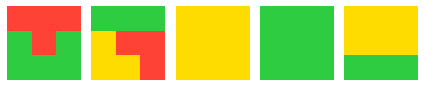

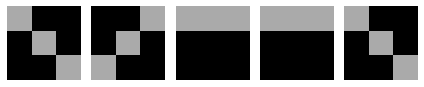

In [9]:
training_path = "/Users/aysjajohnson/Desktop/ARC-master/data/training/"
solver = ARCSolver(task_filename=os.path.join(training_path, '6e02f1e3.json'))
solver.plot_grids(solver.train_inputs)
solver.plot_grids(solver.train_outputs)

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


ValueError: unknown file extension: .mp4

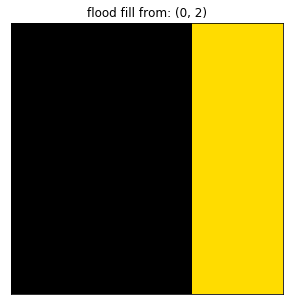

In [10]:
solver = ARCSolver(task_filename=os.path.join(training_path, '6e02f1e3.json'))

fig = plt.figure(figsize=(5, 5))
ax = plt.axes(xlim=(-.5, 4.5), ylim=(-0.5, 4.5))
norm = colors.Normalize(vmin=0, vmax=9)
im = plt.imshow(solver.test_pred, cmap=solver.cmap, norm=norm)
plt.gca().invert_yaxis()
plt.xticks([])
plt.yticks([])

# initialization function: plot the background of each frame
def init():
    # TODO: modify initialization
    im.set_data(solver.test_pred)
    return [im]

# animation function.  This is called sequentially
def animate(i):
    # TODO: replace the two function calls below with a generic next() function
    # or something like that
    r = np.random.choice([0, 1, 2, 3, 4, 5, 6, 7, 8])
    if r == 0:
        solver.change_colour()
    elif r == 1:
        solver.edit()
    elif r == 2:
        solver.resize()
    elif r == 3:
        solver.reset()
    elif r == 4:
        solver.flood_fill()
    elif r == 5:
        solver.copy()
    elif r == 6:
        if solver.clipboard is not None:
            solver.paste()
    elif r == 7:
        solver.copy_from_input()
    elif r == 8:
        solver.edit_rectangle()
    
    #print(solver.description)
    #print(solver.test_pred.shape)
    #plt.gcf().set_size_inches(solver.test_pred_height, solver.test_pred_width, forward=True)
    plt.rcParams["figure.figsize"] = (solver.test_pred_height, solver.test_pred_width)

    im.set_data(solver.test_pred)
    ax.set_title(solver.description)
    return [im]

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=200, blit=False)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
anim.save('basic_animation.mp4', fps=5, extra_args=['-vcodec', 'libx264'])

HTML(anim.to_html5_video())

In [443]:
np.zeros((3, 2)).shape

(3, 2)

In [458]:
for i in range(1):
    print(i)

0
